In [25]:
import pandas as pd
import glob
import os

import numpy as np

import matplotlib.pyplot as plt

In [4]:
def haversine_NM(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers. Use 6371 for kilometers, 3956 for miles.
    r = 6371  # in kilometers
    km_to_NM = 1/1.852
    return c * r * km_to_NM # Distance in kilometers

In [2]:
folder_path = '1998349148'
sensor_id = int(folder_path)

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Concatenate all CSV files into a single DataFrame
df_list = [pd.read_csv(file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)

In [10]:
df_sensor_loc = pd.read_csv('../sensors/sensor_loc.csv')
df['mintime_sensor_date'] = pd.to_datetime(df['mintime_sensor'], unit='s')

sensor_lat = df_sensor_loc[df_sensor_loc['serial'] == sensor_id]['lat'].iloc[0]
sensor_lon = df_sensor_loc[df_sensor_loc['serial'] == sensor_id]['lon'].iloc[0]

df['distance_NM'] = df.apply(lambda row: haversine_NM(row['lat'], row['lon'], sensor_lat, sensor_lon), axis=1)

distance_threshold = 300

df = df[df['distance_NM'] < distance_threshold] ## filter out outliers, theoretically ADS-B receiver max dist is 250

1998349148 51.7 -1.3


In [11]:
df['time_diff'] = df['mintime_sensor_date'].diff().dt.total_seconds().div(60)
df = df[~df['time_diff'].isna()]

# Create a new grouping column: Start a new group if the time difference exceeds 2 minutes
df['group'] = (df['time_diff'] > 2).cumsum()

# Group by the new 'group' column and count the unique 'icao24' values per group
grouped_df = df.groupby('group').agg(
    nb_traffic=('icao24', pd.Series.nunique)
).reset_index()

# Merge the nb_traffic values back onto the original DataFrame based on the group column
df = pd.merge(df, grouped_df, on='group', how='left')

# Drop the 'group' and 'time_diff' columns if you don't need them anymore
df = df.drop(columns=['group', 'time_diff'])

# Assuming df is your DataFrame
# Define bins for 'distance_NM' (10 NM intervals) and 'nb_traffic' (10 interval bins)
max_distance = 300
max_traffic = 300
interval_distance = 10
interval_traffic = 10

distance_bins = pd.cut(df['distance_NM'], bins=range(0, max_distance + interval_distance, interval_distance))
traffic_bins = pd.cut(df['nb_traffic'], bins=range(0, max_traffic + interval_traffic, interval_traffic))

# Create a new DataFrame with binned categories
df['distance_bin'] = distance_bins
df['traffic_bin'] = traffic_bins

# Create a pivot table or crosstab to count how many rows fall into each bin
binned_data = pd.crosstab(df['distance_bin'], df['traffic_bin'])

/var/folders/gt/7bzbbv711312cfd_13h4fkm5z8xgxd/T/ipykernel_22029/3000956027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff'] = df['mintime_sensor_date'].diff().dt.total_seconds().div(60)


In [16]:
filtered_df = df

filtered_df = filtered_df.groupby('icao24', group_keys=True).apply(lambda x: x)
filtered_df['updateinterval'] = filtered_df['mintime_sensor'].diff()
filtered_df = filtered_df[(filtered_df['updateinterval'] < 5) & (filtered_df['updateinterval'] > 0)]
filtered_df = filtered_df.dropna()

# Ungroup and reset index to flatten the DataFrame
filtered_df = filtered_df.reset_index(drop=True)

bin_counts = pd.crosstab(filtered_df['distance_bin'], filtered_df['traffic_bin'])

/var/folders/gt/7bzbbv711312cfd_13h4fkm5z8xgxd/T/ipykernel_22029/2506074053.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('icao24', group_keys=True).apply(lambda x: x)


In [18]:
# Find the pair of distance_bin and traffic_bin with the most data points
max_bin_pair = bin_counts.stack().idxmax()  # This gives the distance_bin and traffic_bin pair
max_bin_count = bin_counts.stack().max()  # This gives the number of data points in the max pair

# Find the pair of distance_bin and traffic_bin with the most data points
max_bin_pair = bin_counts.stack().idxmax()  # This gives the distance_bin and traffic_bin pair

# Filter the DataFrame for the rows that belong to this specific distance_bin and traffic_bin pair
filtered_max_bin_df = filtered_df[
    (filtered_df['distance_bin'] == max_bin_pair[0]) & 
    (filtered_df['traffic_bin'] == max_bin_pair[1])
]

# Ensure that 'updateinterval' exists and add it to the resulting DataFrame
filtered_max_bin_df = filtered_max_bin_df[['distance_bin', 'traffic_bin', 'updateinterval']]

filtered_max_bin_df

,distance_bin,traffic_bin,updateinterval
682,"(40, 50]","(0, 10]",1.115
683,"(40, 50]","(0, 10]",0.919
684,"(40, 50]","(0, 10]",1.115
685,"(40, 50]","(0, 10]",0.522
3464,"(40, 50]","(0, 10]",0.489
...,...,...,...
3999344,"(40, 50]","(0, 10]",0.431
3999345,"(40, 50]","(0, 10]",0.577
3999346,"(40, 50]","(0, 10]",0.442
3999347,"(40, 50]","(0, 10]",0.566


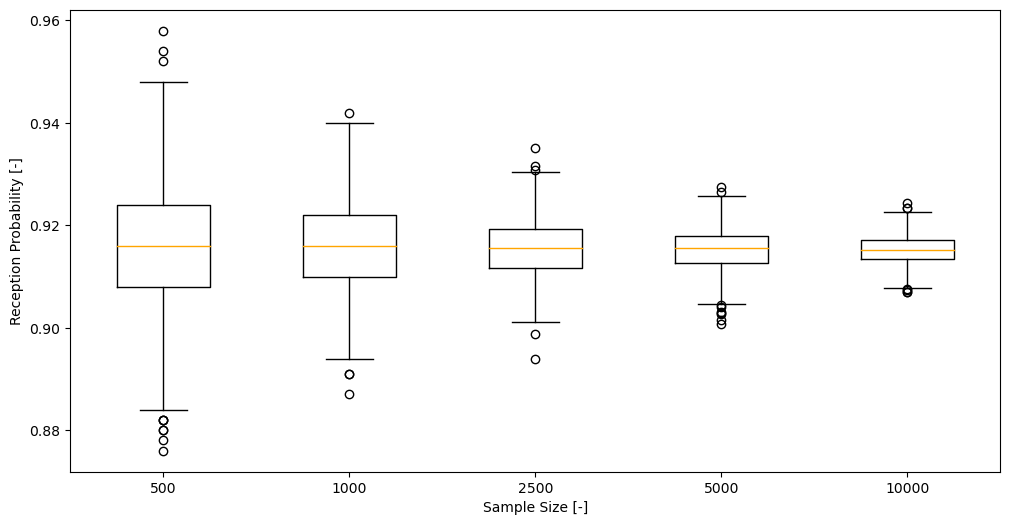

,500,1000,2500,5000,10000
median,0.916,0.916,0.916,0.916,0.915
mean,0.916,0.916,0.915,0.915,0.915
std,0.012,0.009,0.006,0.004,0.003
min,0.876,0.887,0.894,0.901,0.907
max,0.958,0.942,0.935,0.927,0.924


In [73]:
reception_probabilities_dict = {}
n_bootstrap_samples = 1000  # Number of bootstrap iterations

for nb_data in [500, 1000, 2500, 5000, 10000]:
    reception_probabilities = []
    
    for _ in range(n_bootstrap_samples):
        # Sample 2500 rows with replacement from the DataFrame
        sampled_df = filtered_max_bin_df.sample(n=nb_data, replace=True)

        # Calculate histogram for update intervals
        counts, bin_edges = np.histogram(sampled_df['updateinterval'], bins=50)

        # Define the total area (sum of counts) between 0 and 5 seconds
        total_area = counts[(bin_edges[:-1] >= 0) & (bin_edges[:-1] <= 5)].sum()

        # Define the area between 0.25 and 0.75 seconds
        area_025_to_075 = counts[(bin_edges[:-1] >= 0.25) & (bin_edges[:-1] <= 0.75)].sum()

        # Calculate reception probability
        reception_probability = area_025_to_075 / total_area if total_area > 0 else 0
        reception_probabilities.append(reception_probability)
        
    reception_probabilities_dict[nb_data] = reception_probabilities

    # After the loop, you will have a distribution of reception probabilities.

df = pd.DataFrame(reception_probabilities_dict)

# Draw a box plot for each set of reception probabilities
plt.figure(figsize=(12, 6))
boxprops = dict(color="black")  # Set the color for the box outline
medianprops = dict(color="orange")  # Set the color for the median line
whiskerprops = dict(color="black")  # Set the color for the whiskers (vertical lines)

# Draw the box plot with the updated properties
df.boxplot(showfliers=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

# plt.title('Reception Probabilities for Different Sample Sizes')
plt.ylabel('Reception Probability [-]')
plt.xlabel('Sample Size [-]')
plt.xticks([1, 2, 3, 4, 5], [500, 1000, 2500, 5000, 10000])
plt.grid(False)

# table_data = summary_stats.values
# columns = ['1000', '2500', '5000', '10000']
# rows = ['Median', 'Mean', 'Std Dev', 'Min', 'Max']

# # Add table to plot, smaller and positioned inside the plot
# the_table = plt.table(cellText=table_data, rowLabels=rows, colLabels=columns, 
#                       loc='upper right', bbox=[0.65, 0.0, 0.3, 0.3])

# the_table.auto_set_font_size(False)
# the_table.set_fontsize(11)

plt.show()

summary_stats = df.describe().loc[['mean', 'std', 'max', 'min']]
summary_stats.loc['median'] = df.median()

summary_stats = summary_stats.loc[['median', 'mean', 'std', 'min', 'max']]
summary_stats = summary_stats.round(3)
summary_stats